In [9]:
import sklearn
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

In [10]:
class HASH_FUNS():
    def __init__(self, data):
        '''
        Initialize raw data, max value(C), dimension(d), 
            number of points(N), and an array maintaining the cluster index of each point
        
        self.points_distances reflect the true distance of two points. The init value is inf.
        self.RP reflect whether two points is near or note. "near" means the true distance is less than r.
        self.latest_cluster reflect the cluster label of each point, the init value is the points index.
        self.total_number_of_cluster reflect the total number of cluster. NOTE: It is not the current number of clusters.
        '''
        try:
            self.data = data
            if not data.dtype == int:
                raise TypeError
            
            self.C = self.data.max()
            if self.data.min() < 0:
                raise ValueError
            
            self.d = len(self.data[0])
            self.N = len(self.data)


            self.points_distances = np.array([np.array([np.inf] * self.N)] *
                                             self.N)
            
            self.RP = np.array([np.array([False] * self.N)] * self.N)            
            self.latest_cluster = np.arange(self.N)            
            self.total_number_of_cluster = self.N            
            self.single_linkage_matrix = []
            self.iteration_times = 0
            
        except AttributeError:
            print("Data size should be larger than 1")
        except TypeError:
            print("Data should be integers.")
        except ValueError:
            print("Data should be positive.")

    def set_parameters(self, k, l, A=2, T=0):
        '''Set up number of sampled digits(k), number of hash functions(l),
            increasing rate(A), noise exclusion threshold(T), and range of cluster inclusion r'''
        try:
            self.k = k
            if k <= 0 or not isinstance(k, int):
                raise ValueError("k should be positive integer.")
            if k > self.C*self.d:
                raise ValueError("k should be smaller than", self.C*self.d)
            self.l = l
            if l <= 0 or not isinstance(l, int):
                raise ValueError("l should be a positive integer.")
            self.A = A
            if A <= 0:
                raise ValueError("A should be positive.")
            self.T = T
            self.r = self.C*self.d/(2*self.k)*self.d**0.5
            if T > l:
                pass
            elif T <= l and T > 0:
                raise ValueError("T should be larger than l.")
            elif T < 0:
                raise ValueError("T should be non-negative.")
                
            self.create_BP()
        except ValueError:
            print('Some inputs are not right.')
            raise     
    
    def get_parameters(self):
        '''Show the current parameters'''
        print('l=',self.l,'\n')
        print('k=',self.k,'\n')
        print('r=',self.r,'\n')
        print('C=',self.C,'\n')
        print('d=',self.d,'\n')
        print('N=',self.N,'\n')
        print('A=',self.A,'\n')
        print('T=',self.T,'\n')

    def plot_raw_data(self):
        '''Plot the points on a 2d grid. Only 2d data allowed'''
        plt.scatter(self.data[:, 0], self.data[:, 1])        
        
    def fit_data(self):
        """
        Train data until all data merge into one cluster, during each phase, this function will update points distance
        and single linkage matrix.
        
        During each phase, the function will update r and k automatically, and the noise exclusion will 
        only be intergrated into the first phase.        
        """
        while len(self.latest_cluster[self.latest_cluster ==
                                      self.latest_cluster[0]]) != self.N:
            self.update_distance()
            self.update_RP()
            self.update_single_linkage_matrix()
            self.r = self.r * self.A
            self.k = int(self.C * self.d * np.sqrt(self.d) / (2 * self.r))
            self.iteration_times += 1
        return self.single_linkage_matrix
    
    def update_distance(self):
        """
        This function will update distance in every phase.
        
        self.near_points reflect the number of points near the point in every bucket.
        
        self.hash_value function return a matrix, which shape is (l * N * k). It contains l hash tables.
        for each hash table, we calculate the bucket and for each bucket, we calculate the points distances.
        """
        self.near_points = np.zeros(self.N)
        for hash_table in self.hash_value():
            candidates = self.identify_candidates(hash_table)
            for lis in candidates:
                self.judge_cluster_by_distance(lis)
        print('already update points distance')

    def update_RP(self):
        """
        self.RP identify each two points is near or not.
            if two points p q is near, then self.RP[p,q] is True.
        
        self.not_noise_points is only used in the first phase, which will be used to judge noise point.
            if one points p is not noise, then the value is True.     
            
        self.near_points reflect the near points of the point p in all bucket in all hash functions. 
        self.core_points reflect whether the near points of the point p is bigger than T.
        """
        
        temp = self.points_distances < self.r
        self.RP += temp     
        
        if self.iteration_times == 0:
            self.not_noise_points = np.array([False] * self.N)
            self.core_points = self.near_points > self.T
            self.not_noise_points += self.core_points

            for i in range(self.N):
                if self.core_points[i]:
                    self.not_noise_points += self.RP[i]
        else:
            self.not_noise_points = np.array([True]* self.N)
        #print(self.not_noise_points)

    def update_single_linkage_matrix(self):
        """
        The single linkage matrix has four columns. The first two columns are the cluster label, the third columns
            is the distance of two cluster, and the fourth columns is the number of points in the new merged cluster.
            
        In the first phase, we will only count the not noise points.
        """
        
        for i in range(self.N):
            if not self.not_noise_points[i]:
                continue
            for j in range(i + 1, self.N):
                ele = self.RP[i, j]
                if ele and self.latest_cluster[i] != self.latest_cluster[j]:
                    temp1 = self.latest_cluster[i]
                    temp2 = self.latest_cluster[j]

                    temp = self.update_latest_cluster(i, j)
                    row = [temp1, temp2, self.r, temp]
                    self.single_linkage_matrix.append(row)
                    

    def update_latest_cluster(self, i, j):
        """
        input: near points i, j
        ouput: the total number of cluster.
        
        For near points i,j, this functions first identify the two cluster of two points and relabel all points in this 
            two clusters into a new label, which means "merge" two cluster.
        """
        
        temp = self.total_number_of_cluster
        self.latest_cluster[self.latest_cluster ==
                            self.latest_cluster[i]] = temp
        self.latest_cluster[self.latest_cluster ==
                            self.latest_cluster[j]] = temp
        self.total_number_of_cluster += 1
        return len(self.latest_cluster[self.latest_cluster == temp])

    def create_BP(self):
        '''Create a binary table. Each row is a Cd-dimensional vector 
            transformed from the d-dimensional vector'''        
        self.r = self.C * self.d / (2 * self.k) * np.sqrt(self.d)
        self.BP = np.zeros((self.N, self.C * self.d), dtype='int')
        for i in range(self.N):
            for k in range(self.d):
                start_point = self.C * k
                number_of_one = self.data[i][k]
                self.BP[i][start_point:start_point + number_of_one] = 1
        #print("already create binary table")
        return self.BP

    def create_hash_table(self):
        '''Create a hashed table. Each row has k bits randomly chosen 
            from the Cd-dimensional vector. '''        
        choice_value = np.random.randint(low=0,
                                         high=self.C * self.d,
                                         size=self.k)
        hash_table = self.BP[:, choice_value]
        return hash_table

    def hash_value(self):
        """
        Return a matrix with shape (l * N * k). This matrix contains l hash table.
        """
        
        table = np.zeros((self.l, self.N, self.k), dtype='int')
        for i in range(self.l):
            table[i, :, :] = self.create_hash_table()
        #print("already create hash function")
        return table

    def identify_candidates(self, A):
        """
        input: one hash table
        output: buckets
        
        this function calculate the buckets in one hash table. For each point p, it put the points with same hash value
            into the buckets. 
        However,if another point belonging to the same cluster as p has already been saved in the very bucket, 
            p is not stored in it.
        """
        
        result = []
        N = len(A)
        K = A.copy()
        for i in range(N):
            target = A[i]
            temp = [i]
            for j in range(i, N):
                if i == j:
                    continue
                if self.latest_cluster[i] == self.latest_cluster[j]:
                    continue
                can = A[j]
                if (target == can).all():
                    temp.append(j)
            if sorted(temp) not in result:
                result.append(sorted(temp))
        return result

    def judge_cluster_by_distance(self, lis):
        """
        input: one bucket
        
        This function will update the points_distances in one bucket. 
        For points_distance < r, count points' near points' number.
        """
        N = len(lis)
        for i in range(N):
            for j in range(N):
                par_points = (lis[i], lis[j])
                if self.points_distances[par_points] == np.inf:
                    dis = np.linalg.norm(self.data[lis[i]] - self.data[lis[j]])
                    self.points_distances[par_points] = dis
                    self.points_distances[par_points[::-1]] = dis
                else:
                    dis = self.points_distances[par_points]
                if self.iteration_times == 0 and dis < self.r:
                    self.near_points[lis[i]] += 1

example1

already update points distance
already update points distance
already update points distance


{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [10.0, 10.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [42.5, 42.5, 65.0, 65.0],
  [53.75, 53.75, 75.0, 75.0],
  [17.5, 17.5, 64.375, 64.375]],
 'dcoord': [[0.0, 1.125, 1.125, 0.0],
  [1.125, 1.125, 1.125, 0.0],
  [0.0, 1.125, 1.125, 0.0],
  [0.0, 1.125, 1.125, 1.125],
  [1.125, 1.125, 1.125, 0.0],
  [1.125, 2.25, 2.25, 0.0],
  [1.125, 4.5, 4.5, 2.25]],
 'ivl': ['1', '5', '6', '2', '0', '4', '7', '3'],
 'leaves': [1, 5, 6, 2, 0, 4, 7, 3],
 'color_list': ['g', 'g', 'r', 'r', 'r', 'r', 'b']}

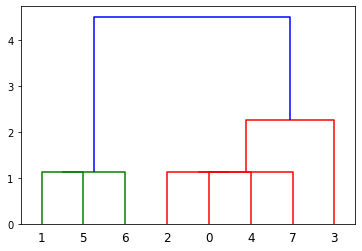

In [11]:
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
X = np.array(X)
test2 = HASH_FUNS(X)
test2.set_parameters(4,10,2,11)
output = test2.fit_data()
dendrogram(output)

example2

In [12]:
data = sklearn.datasets.load_iris().data
data = data[:,:]*10 - data.min(axis=0)*10
data = np.array(data, dtype='int')

test = HASH_FUNS(data)
test.set_parameters(100,10,2,15)
pass
output = test.fit_data()

already update points distance
already update points distance
already update points distance
already update points distance


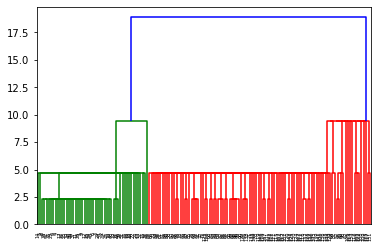

In [14]:
dendrogram(output)
pass